# Image classifier for the SVHN dataset

In this notebook, I will create a neural network that classifies real-world images digits. I will use concepts such as building, training, testing, validating and saving a Tensorflow classifier model.


## Libraries

In [21]:
import tensorflow as tf
from scipy.io import loadmat
import random 
import numpy as np

![SVHN overview image](data/svhn_examples.jpg)
The [SVHN dataset](http://ufldl.stanford.edu/housenumbers/) is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

My is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

## Loading the dataset

In [22]:
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

FileNotFoundError: [Errno 2] No such file or directory: 'train_32x32.mat'

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset


### Extract the training and testing images and labels separately from the train and test dictionaries

In [87]:
X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0
X_train.shape
X_test.shape

(32, 32, 3, 26032)

### Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.

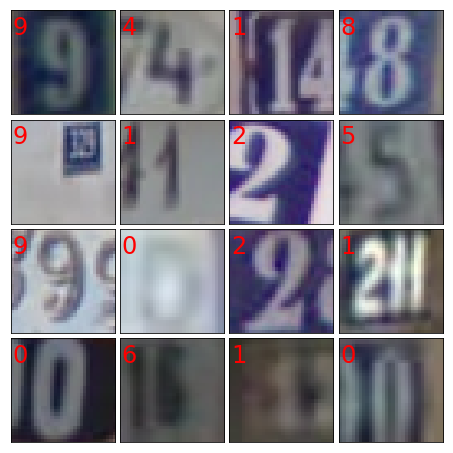

In [88]:
r_indexes = random.sample(range(0, 73257), 16)
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (6,6)) # figure size in inches
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for i in range(len(r_indexes)):
    ax = fig.add_subplot(4, 4, i+1, xticks = [], yticks = [])
    ax.imshow(X_train[:,:,:,r_indexes[i]], interpolation = 'nearest')
    ax.text(0, 7, str(y_train[r_indexes[i]][0]), color = 'red', fontsize = 24)


### Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. I will retain the channel dimension, which will now have size 1.

In [89]:
X_train_grey = []

for i in range(73257):
    grey_image = np.mean(X_train[:, :, :, i], axis = 2)
    grey_image = grey_image[..., np.newaxis]
    X_train_grey.append(grey_image)
X_train_grey = np.array(X_train_grey)
#X_train_grey = np.moveaxis(X_train_grey, [0], [3])
X_train_grey.shape

(73257, 32, 32, 1)

In [90]:
X_test_grey = []
for i in range(26032):
    grey_image = np.mean(X_test[:, :, :, i], axis = 2)
    grey_image = grey_image[..., np.newaxis]
    X_test_grey.append(grey_image)
X_test_grey = np.array(X_test_grey)
#X_test_grey = np.moveaxis(X_test_grey, [0], [3])
X_test_grey.shape

(26032, 32, 32, 1)

### Select a random sample of the grayscale images and corresponding labels from the dataset and display them in a figure.

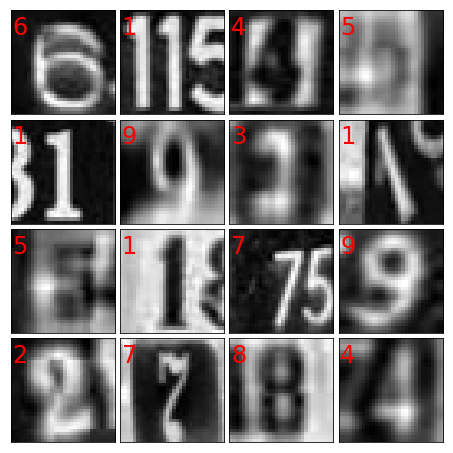

In [92]:
r_indexes = random.sample(range(0, 73257), 16)
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (6,6)) # figure size in inches
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for i in range(len(r_indexes)):
    ax = fig.add_subplot(4, 4, i+1, xticks = [], yticks = [])
    ax.imshow(X_train_grey[r_indexes[i], :, :, 0], cmap = plt.cm.binary, interpolation = 'nearest')
    ax.text(0, 7, str(y_train[r_indexes[i]][0]), color = 'red', fontsize = 24)

## 2. MLP neural network classifier
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

#### Build MLP classifier model(We will only utilize Flatten and Dense layers)

#### Libraries needed for building the model

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers

In [101]:
def get_mlp_model():
    model = Sequential([
        Flatten(input_shape = X_train_grey[0].shape), 
        Dense(512, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"),
        Dense(128, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"), 
        Dense(64, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"),
        Dense(10, activation = "softmax"),
    ])
    return model

#### Model Summary

In [162]:
model = get_mlp_model()
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_28 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_96 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_97 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_98 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_99 (Dense)             (None, 10)                650       
Total params: 599,370
Trainable params: 599,370
Non-trainable params: 0
_________________________________________________________________


### Compilation for the model

In [163]:
def compile_models(m):
    m.compile(optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

In [164]:
model.compile(optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
             metrics = ["accuracy"])

### Defining Callbacks

In [165]:
def get_checkpoint_every_epoch():
    checkpoint_path = "model_checkpoints/checkpoint_{epoch:03d}"
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                 frequency = "epoch",
                                 save_weights_only = True,
                                 verbose = 1)
    return checkpoint

def get_checkpoint_best_only():
    checkpoint_path = "checkpoints_best_only/checkpoint"
    return ModelCheckpoint(filepath = checkpoint_path,
                           save_weights_only= True,
                           monitor = "val_accuracy",
                           save_best_only = True)

def get_checkpoint_best_only_mlp():
    checkpoint_path = "checkpoints_best_only_mlp/checkpoint"
    return ModelCheckpoint(filepath = checkpoint_path,
                           save_weights_only= True,
                           monitor = "val_accuracy",
                           save_best_only = True)    
def get_early_stopping():
    return EarlyStopping(monitor = "loss",
                         patience = 3,
                        verbose = 1)


In [166]:
checkpoint_every_epoch = get_checkpoint_every_epoch()
checkpoint_best = get_checkpoint_best_only_mlp()
early_stopping = get_early_stopping()


### Training the model

In [167]:
def train_models(m, e):
    callbacks = [get_checkpoint_every_epoch(),
                 get_checkpoint_best_only(),
                 get_early_stopping()]
    history = m.fit(x = X_train_grey,
                        y = y_train,
                        epochs = e,
                        validation_split = 0.15,
                        callbacks = callbacks)
    return history
        

In [168]:
callbacks = [checkpoint_every_epoch, checkpoint_best, early_stopping]
history = model.fit(x = X_train_grey, 
          y = y_train,
          epochs = 30,
          validation_split = 0.15,
          callbacks = callbacks)

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62176/62268 [============================>.] - ETA: 0s - loss: 5.6903 - accuracy: 0.1791
Epoch 00001: saving model to model_checkpoints/checkpoint_001
62268/62268 [==============================] - 77s 1ms/sample - loss: 5.6851 - accuracy: 0.1792 - val_loss: 2.1655 - val_accuracy: 0.2481
Epoch 2/30
62240/62268 [============================>.] - ETA: 0s - loss: 1.9901 - accuracy: 0.3406
Epoch 00002: saving model to model_checkpoints/checkpoint_002
62268/62268 [==============================] - 73s 1ms/sample - loss: 1.9899 - accuracy: 0.3407 - val_loss: 1.5617 - val_accuracy: 0.5081
Epoch 3/30
62176/62268 [============================>.] - ETA: 0s - loss: 1.5907 - accuracy: 0.4927
Epoch 00003: saving model to model_checkpoints/checkpoint_003
62268/62268 [==============================] - 73s 1ms/sample - loss: 1.5907 - accuracy: 0.4927 - val_loss: 1.5972 - val_accuracy: 0.5022
Epoch 4/30
62208/62268 [==========================

#### Model Evaluation

In [145]:
def evaluate_models(m):
    test_loss, test_accuracy = m.evaluate(X_test_grey, y_test, verbose = 2)
    print("Test loss: {}".format(test_loss))
    print("Test accuracy: {}".format(test_accuracy))

In [156]:
test_loss, test_accuracy = model.evaluate(X_test_grey, y_test, verbose = 2)
print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_accuracy))

26032/1 - 10s - loss: 0.9698 - accuracy: 0.6969
Test loss: 1.0533421285400086
Test accuracy: 0.6969115138053894


#### Graphs (Check for overfitting)

In [147]:
import pandas as pd
frame = pd.DataFrame(history.history)
frame.head()

,loss,accuracy,val_loss,val_accuracy
0,5.932148,0.160114,2.162475,0.247611
1,1.927464,0.365324,1.634188,0.471926
2,1.582403,0.495969,1.462529,0.561016
3,1.424135,0.559902,1.390332,0.567113
4,1.325090,0.594206,1.352927,0.585131


In [148]:
def plot_acc(h):
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title("Accuracy vs Epochs")
    plt.ylabel('Accuracy')
    plt.xlabel("Epoch")
    plt.legend(['Training', 'Validation'], loc = "lower right")
    plt.show()

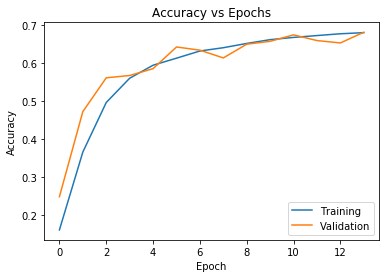

In [149]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy vs Epochs")
plt.ylabel('Accuracy')
plt.xlabel("Epoch")
plt.legend(['Training', 'Validation'], loc = "lower right")
plt.show()

In [150]:
def plot_loss(h):
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title("Loss vs Epochs")
    plt.ylabel('Loss')
    plt.xlabel("Epoch")
    plt.legend(['Training', 'Validation'], loc = "upper right")
    plt.show()

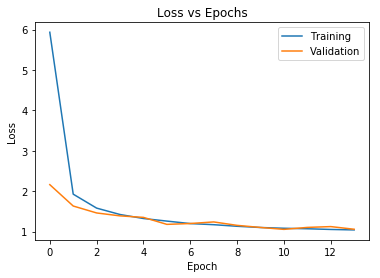

In [151]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss vs Epochs")
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(['Training', 'Validation'], loc = "upper right")
plt.show()

## 3. CNN neural network classifier

* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

### CNN Construction (We will only use Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers.)

#### Missing libraries

In [122]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [123]:
def get_cnn_model(input_shape):
    model = Sequential([
        Conv2D(16, (3, 3),
               padding = "SAME",
               activation = "relu",
               input_shape = input_shape),
        Conv2D(8, (3, 3),
               padding = "SAME",
               activation = "relu"),
        MaxPooling2D(pool_size = (8, 8)),
        Flatten(),
        Dense(128, activation = "relu", kernel_regularizer = regularizers.l2(1e-5)), 
        Dense(64, activation = "relu", kernel_regularizer = regularizers.l2(1e-5)),
        Dense(10, activation = "softmax")
    ])
    return model

In [124]:
model_cnn = get_cnn_model(X_train_grey[0].shape)
model_cnn.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_79 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_80 (Dense)             (None, 10)              

### Compilation and Trainining

In [125]:
compile_models(model_cnn)

In [126]:
history = train_models(model_cnn, 10)

Train on 62268 samples, validate on 10989 samples
Epoch 1/10
62240/62268 [============================>.] - ETA: 0s - loss: 2.1814 - accuracy: 0.2531
Epoch 00001: saving model to model_checkpoints/checkpoint_001
62268/62268 [==============================] - 363s 6ms/sample - loss: 2.1811 - accuracy: 0.2532 - val_loss: 1.5694 - val_accuracy: 0.4853
Epoch 2/10
62240/62268 [============================>.] - ETA: 0s - loss: 1.2496 - accuracy: 0.5967
Epoch 00002: saving model to model_checkpoints/checkpoint_002
62268/62268 [==============================] - 353s 6ms/sample - loss: 1.2493 - accuracy: 0.5968 - val_loss: 0.8641 - val_accuracy: 0.7284
Epoch 3/10
62240/62268 [============================>.] - ETA: 0s - loss: 0.7637 - accuracy: 0.7645
Epoch 00003: saving model to model_checkpoints/checkpoint_003
62268/62268 [==============================] - 350s 6ms/sample - loss: 0.7637 - accuracy: 0.7646 - val_loss: 0.7011 - val_accuracy: 0.7846
Epoch 4/10
62240/62268 [=======================

#### Graphs

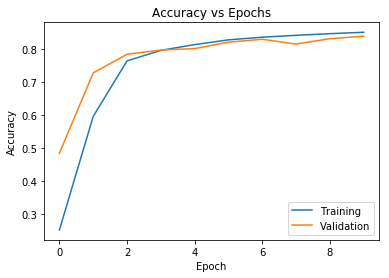

In [127]:
plot_acc(history)

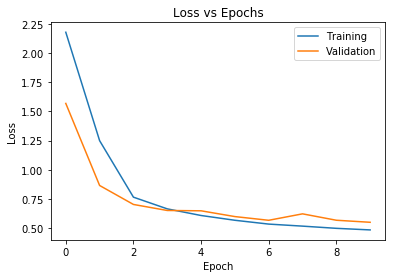

In [128]:
plot_loss(history)

#### Evaluation

In [129]:
evaluate_models(model_cnn)

26032/1 - 38s - loss: 0.5426 - accuracy: 0.8307
Test loss: 0.5858306852343922
Test accuracy: 0.8306699395179749


In [130]:
!ls checkpoints_best_only_mlp

checkpoint  checkpoint.data-00000-of-00001  checkpoint.index


## 4. Get model predictions
I will now load the best weights for the MLP and CNN. I will then randomly select 5 images and their corresponding labels from the test set, and display the images with their labels. Alongside the image and label I will show each model's predictive distribution as a bar chart, and the final final model prediction given by the label with maximum probability. 

In [131]:
def get_model_best_epoch(m):
    checkpoint_path = "checkpoints_best_only/checkpoint"
    m.load_weights(checkpoint_path)
    return m
def get_model_best_epoch_mlp(m):
    checkpoint_path = "checkpoints_best_only_mlp/checkpoint"
    m.load_weights(checkpoint_path)
    return m

#### Load best models

In [132]:
best_model_cnn = get_model_best_epoch(get_cnn_model(X_train_grey[0].shape))
best_model_mlp = get_model_best_epoch_mlp(get_mlp_model())

#### Random images and figure

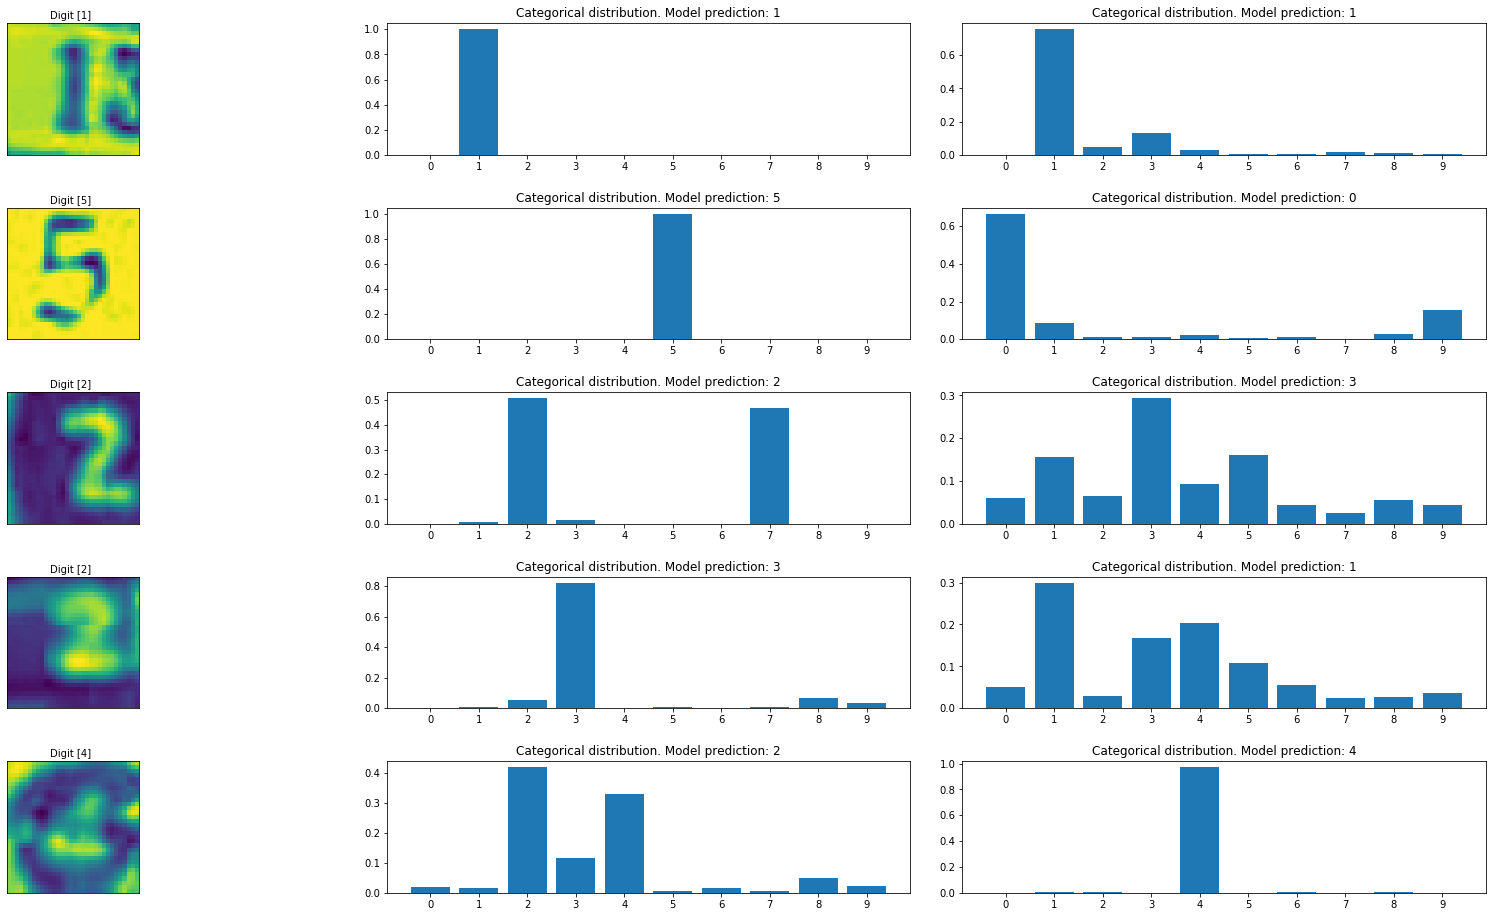

In [135]:
num_test_images = X_test_grey.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test_grey[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions_cnn = best_model_cnn.predict(random_test_images)
predictions_mlp = best_model_mlp.predict(random_test_images)

fig, axes = plt.subplots(5, 3, figsize = (30, 16))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i, (p_cnn, p_mlp, image, label) in enumerate(zip(predictions_cnn, predictions_mlp, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(p_cnn)), p_cnn)
    axes[i, 1].set_xticks(np.arange(len(p_cnn)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(p_cnn)}")
    axes[i, 2].bar(np.arange(len(p_mlp)), p_mlp)
    axes[i, 2].set_xticks(np.arange(len(p_mlp)))
    axes[i, 2].set_title(f"Categorical distribution. Model prediction: {np.argmax(p_mlp)}")
